<a href="https://colab.research.google.com/github/Aadil404/Machine-Learning-Lab/blob/main/Assignment-3/Assignment_3_3_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, Reshape, LSTM, AveragePooling2D, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from itertools import cycle

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
# Load the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print("Shape of training data:", x_train_full.shape)
print("Shape of test data:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Shape of training data: (50000, 32, 32, 3)
Shape of test data: (10000, 32, 32, 3)


In [3]:
# Function to plot training history (accuracy and loss)
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{model_name} Training History', fontsize=16)

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC/AUC curves
def plot_roc_auc(y_true, y_pred_proba, n_classes, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) for {model_name}', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# --- AlexNet ---
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        # Layer 1
        Conv2D(96, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        # Layer 2
        Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        # Layer 3, 4, 5
        Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        # Classifier
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# --- GoogLeNet (Simplified Inception Module) ---
def inception_module(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters
    layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return layer_out

def build_googlenet(input_shape=(32, 32, 3), num_classes=10):
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = AveragePooling2D((4, 4))(x) # Use AveragePooling to reduce dimensions
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    return model


# --- VGG-16 ---
def build_vgg16(input_shape=(32, 32, 3), num_classes=10):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Freeze the convolutional base
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# --- RNN (with LSTM) ---
# Note: RNNs are not ideal for image classification. We treat each row of pixels as a time step.
def build_rnn(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        # Reshape input to (timesteps, features)
        Reshape((input_shape[0], input_shape[1] * input_shape[2]), input_shape=input_shape),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [5]:
# --- Configuration ---
SPLITS = [0.1, 0.2] # Corresponds to 90/10 and 80/20 train/validation splits
EPOCHS = 15
BATCH_SIZE = 64

# Dictionary to store all our results
results = {}

# Dictionary of models to train
models_to_train = {
    "VGG-16": build_vgg16,
    "AlexNet": build_alexnet,
    "GoogLeNet": build_googlenet,
    "RNN (LSTM)": build_rnn,
}

In [6]:
best_models = {}

for model_name, model_builder in models_to_train.items():
    print(f"\n==================== Training {model_name} ====================")
    best_accuracy = 0.0

    for split_val in SPLITS:
        print(f"\n----- Using Validation Split: {split_val*100:.0f}% -----")

        # Split the training data into training and validation sets
        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=split_val, random_state=42
        )

        # Build and compile the model
        model = model_builder()
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(x_val, y_val),
                            verbose=1) # Set to 1 to see progress

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

        # Store results
        result_key = f"{model_name} (Val Split {split_val*100:.0f}%)"
        results[result_key] = {'test_loss': test_loss, 'test_accuracy': test_acc}
        print(f"Test Accuracy for {result_key}: {test_acc:.4f}")

        # Check if this is the best model so far
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_models[model_name] = {
                'model': model,
                'history': history,
                'test_accuracy': test_acc,
                'split': split_val
            }

print("\n==================== Training Complete ====================")

==================== Training VGG-16 ====================

----- Using Validation Split: 10% -----
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.4178 - loss: 1.6458 - val_accuracy: 0.5590 - val_loss: 1.2619
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5482 - loss: 1.2864 - val_accuracy: 0.5624 - val_loss: 1.2331
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5737 - loss: 1.2179 - val_accuracy: 0.6014 - val_loss: 1.1465
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5888 - loss: 1.1726 - val_accuracy: 0.5948 - val_loss: 1.1515
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5958 - loss: 1.1475 - val_accuracy: 0.6062 - val_loss: 1.1276
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6063 - loss: 1.1305 - val_accuracy: 0.6038 - val_loss: 1.1157
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6096 - l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3453 - loss: 2.1515 - val_accuracy: 0.5014 - val_loss: 1.3562
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5750 - loss: 1.2064 - val_accuracy: 0.5458 - val_loss: 1.3580
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6660 - loss: 0.9788 - val_accuracy: 0.6474 - val_loss: 1.0133
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7135 - loss: 0.8451 - val_accuracy: 0.6572 - val_loss: 1.0132
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7484 - loss: 0.7435 - val_accuracy: 0.4838 - val_loss: 1.3856
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.7793 - loss: 0.6551 - val_accuracy: 0.7506 - val_loss: 0.7761
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8148 - loss: 0.5504 - val_accuracy: 0.7334 - val_loss: 0.8283
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8396 - loss: 0.4898 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2311 - loss: 2.0694 - val_accuracy: 0.3716 - val_loss: 1.7277
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3778 - loss: 1.7225 - val_accuracy: 0.4244 - val_loss: 1.5700
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4309 - loss: 1.5935 - val_accuracy: 0.4484 - val_loss: 1.4877
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4616 - loss: 1.5007 - val_accuracy: 0.4808 - val_loss: 1.4248
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4873 - loss: 1.4301 - val_accuracy: 0.4830 - val_loss: 1.4315
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5105 - loss: 1.3657 - val_accuracy: 0.5014 - val_loss: 1.3811
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5383 - loss: 1.3173 - val_accuracy: 0.5240 - val_loss: 1.3116
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5519 - loss: 1.2655 - val_accuracy


--- Generating plots for best VGG-16 (Val Split: 10%) ---


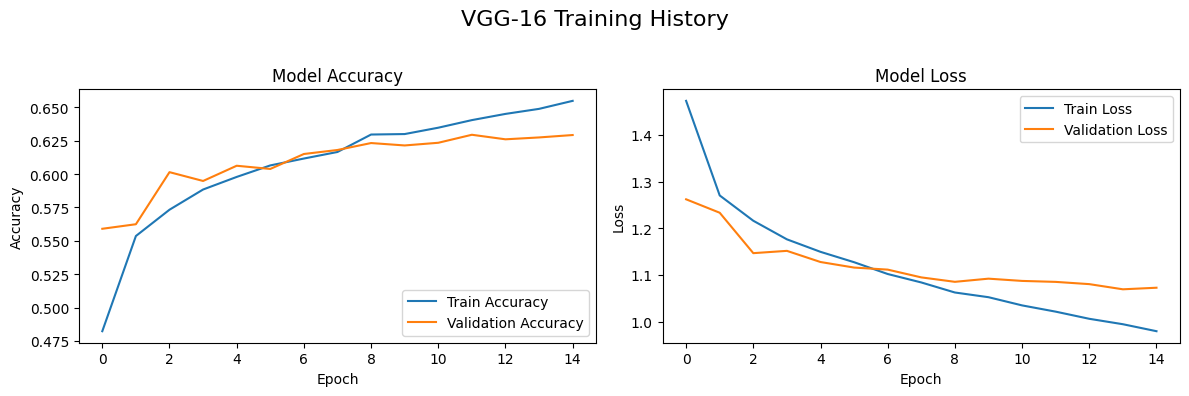

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


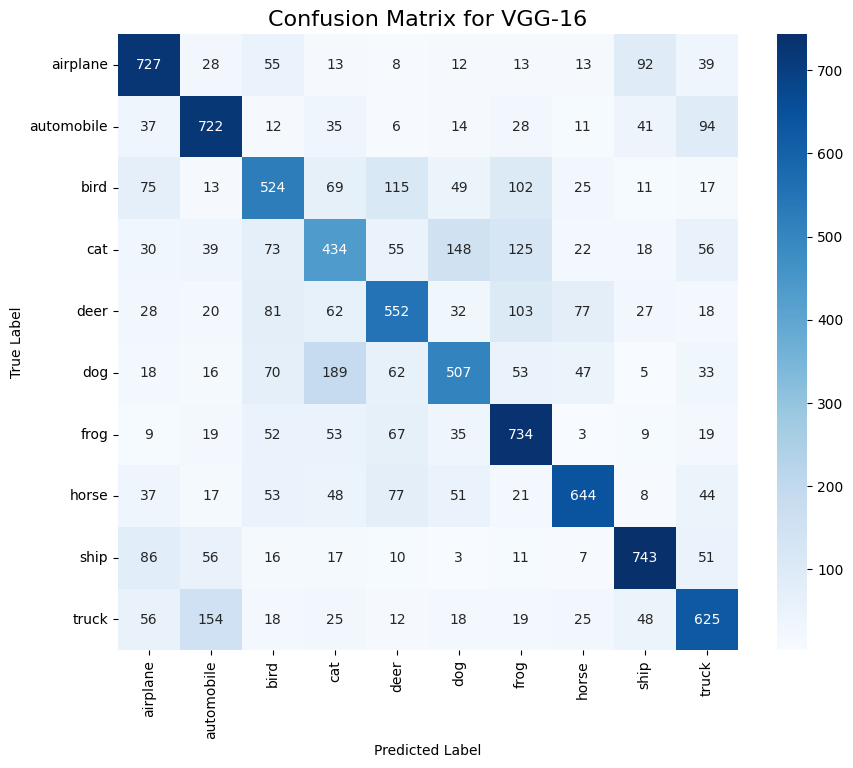

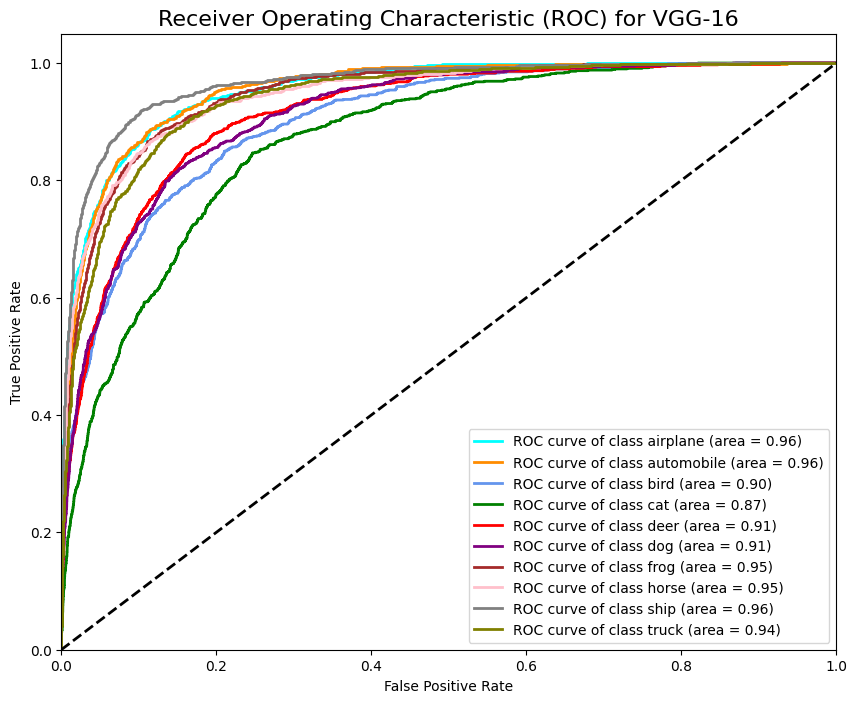


--- Generating plots for best AlexNet (Val Split: 10%) ---


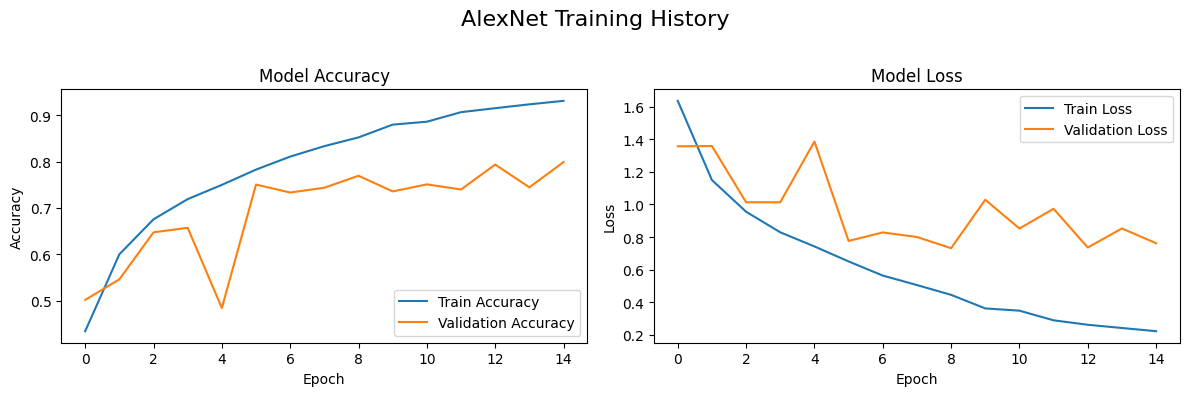

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


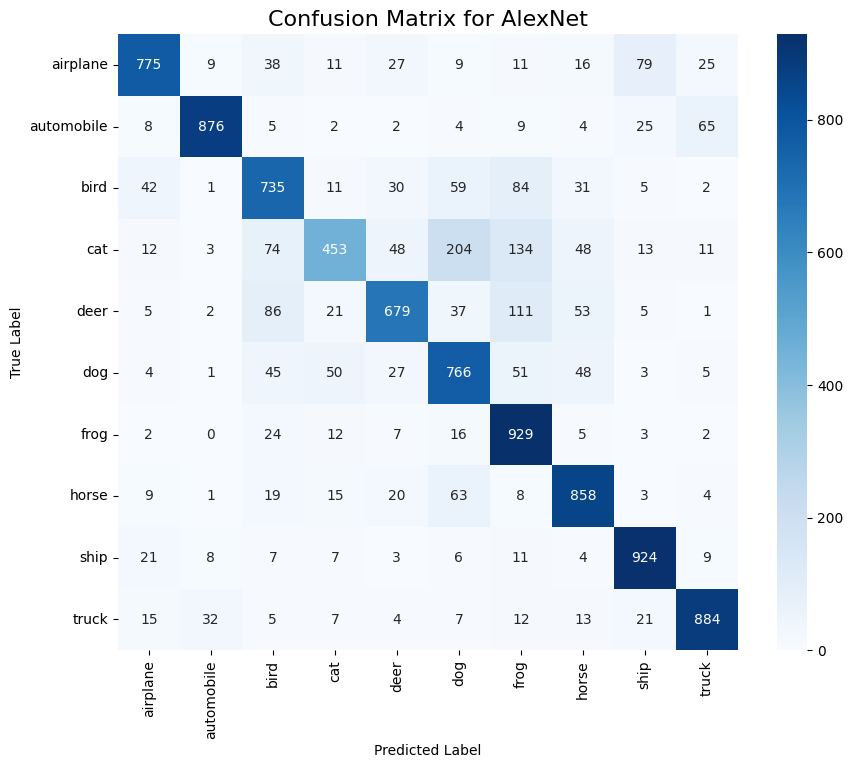

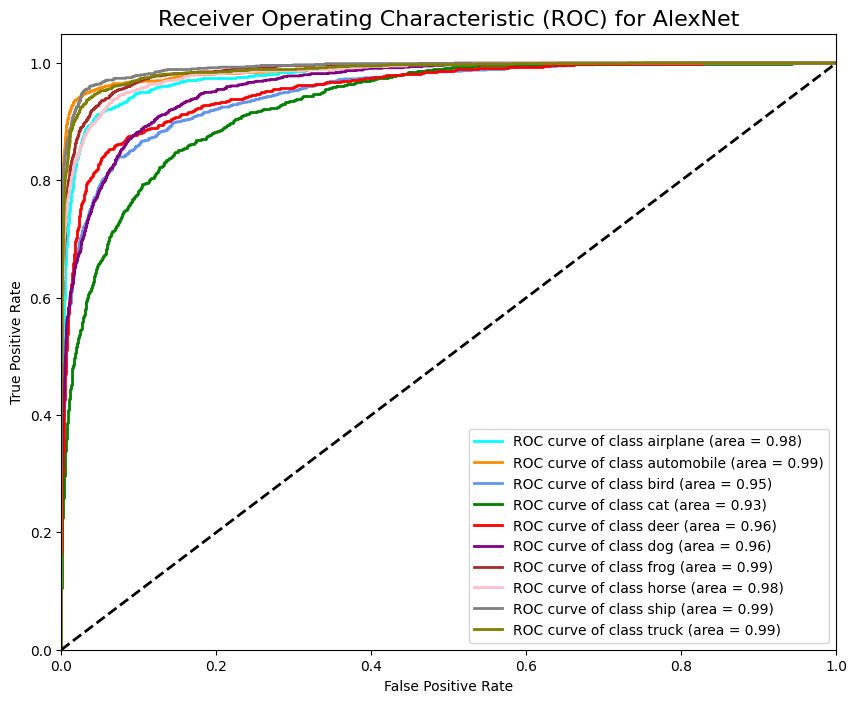


--- Generating plots for best GoogLeNet (Val Split: 10%) ---


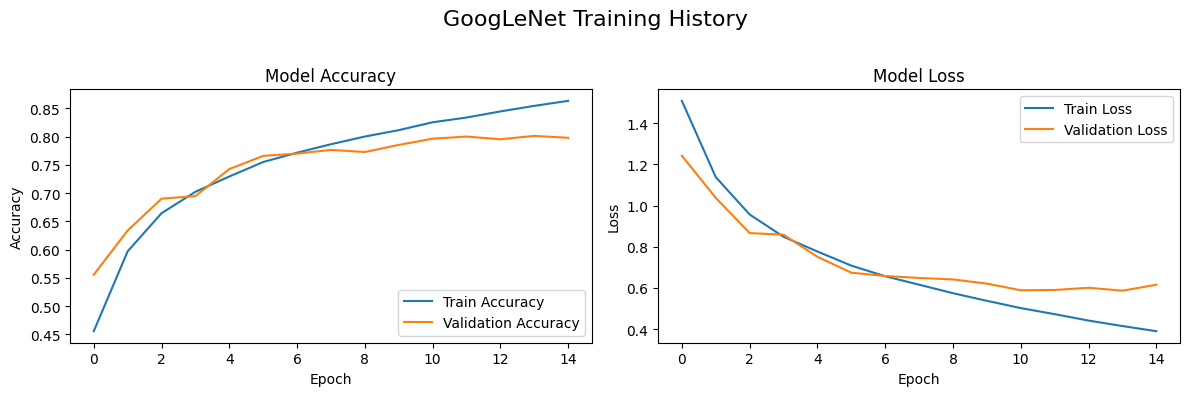

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


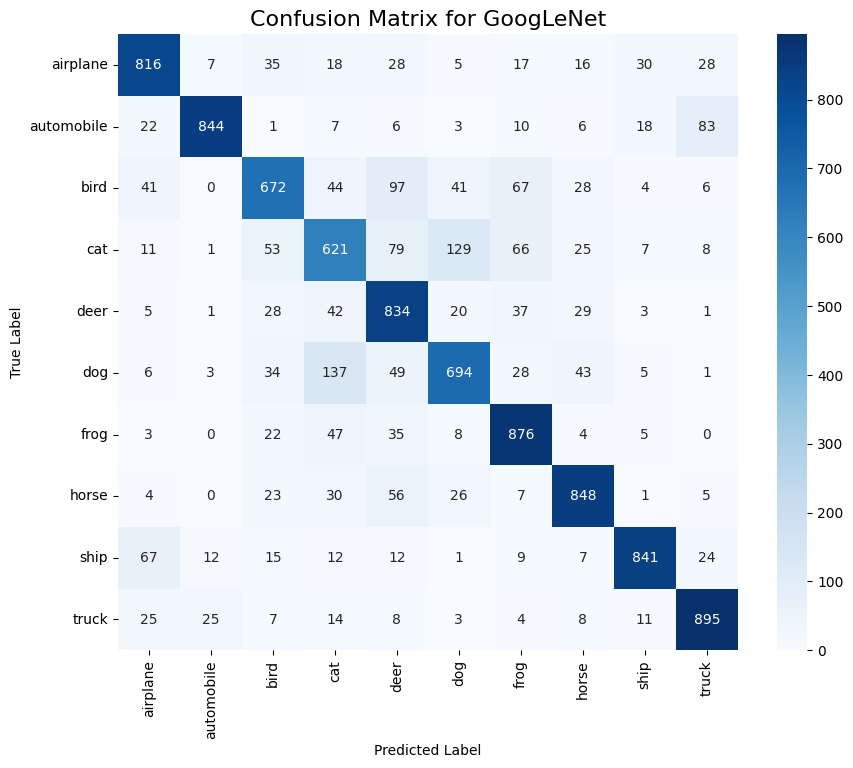

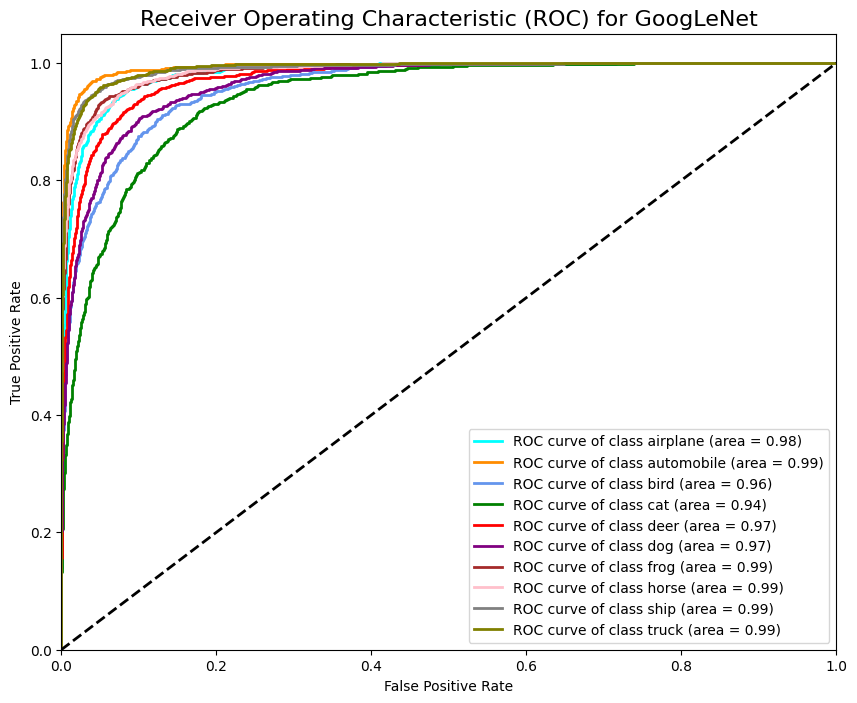


--- Generating plots for best RNN (LSTM) (Val Split: 10%) ---


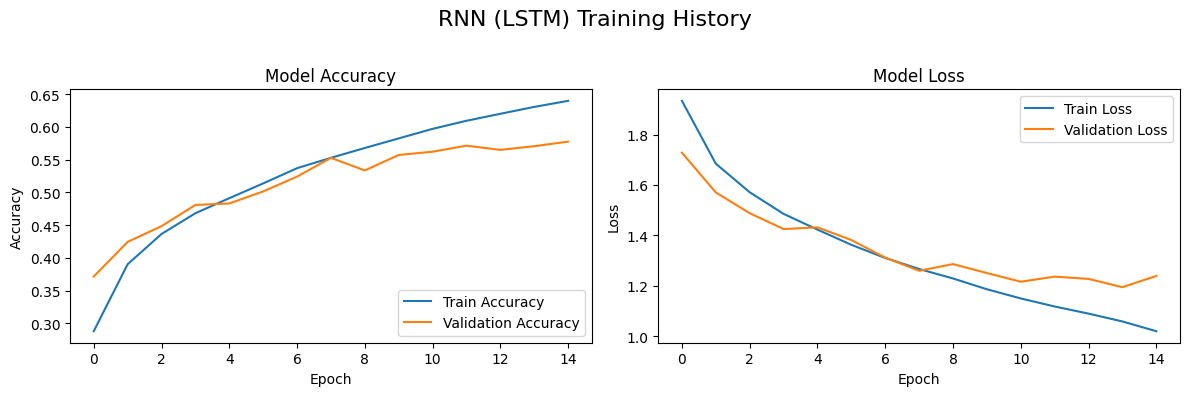

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


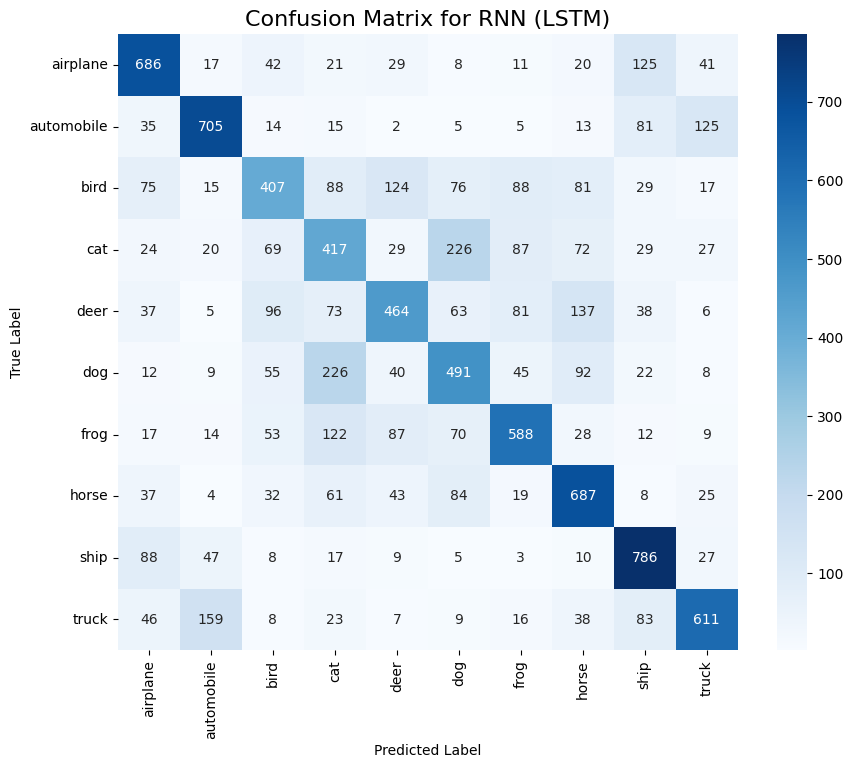

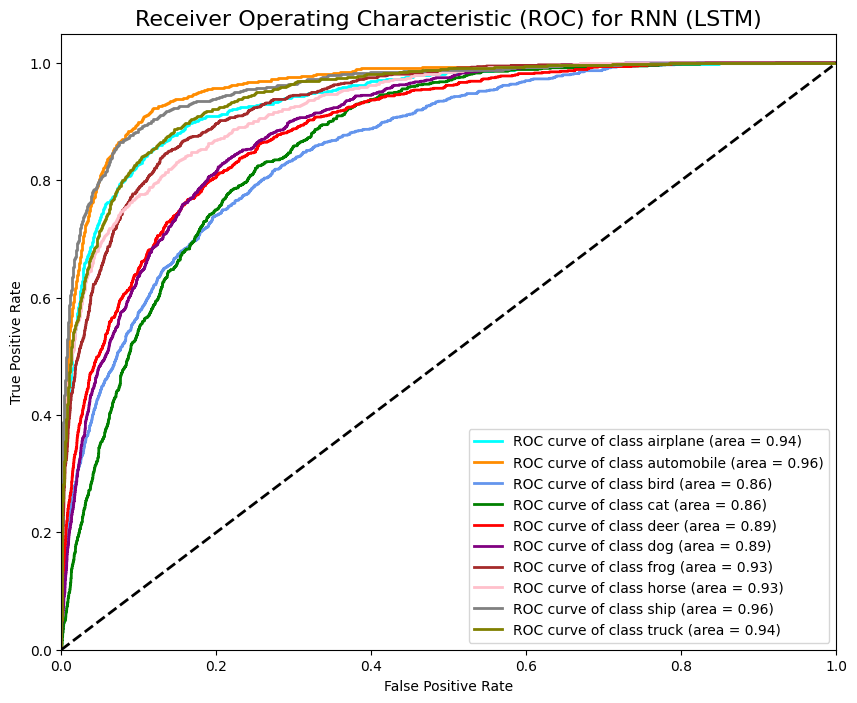

In [7]:
for model_name, data in best_models.items():
    print(f"\n--- Generating plots for best {model_name} (Val Split: {data['split']*100:.0f}%) ---")

    model = data['model']
    history = data['history']

    # 1. Plot Training & Validation Curves
    plot_history(history, model_name)

    # 2. Generate predictions for confusion matrix and ROC
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # 3. Plot Confusion Matrix
    plot_confusion_matrix(y_test_labels, y_pred, class_names, model_name)

    # 4. Plot ROC/AUC Curve
    plot_roc_auc(y_test, y_pred_proba, n_classes=len(class_names), model_name=model_name)

In [8]:
# Convert results dictionary to a Pandas DataFrame for easy viewing
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_index()

print("==================== Performance Comparison ====================")
print(results_df)

==================== Performance Comparison ====================
                            test_loss  test_accuracy
AlexNet (Val Split 10%)      0.812362         0.7879
AlexNet (Val Split 20%)      1.008787         0.7647
GoogLeNet (Val Split 10%)    0.623932         0.7941
GoogLeNet (Val Split 20%)    0.624876         0.7903
RNN (LSTM) (Val Split 10%)   1.214281         0.5842
RNN (LSTM) (Val Split 20%)   1.206890         0.5753
VGG-16 (Val Split 10%)       1.087513         0.6212
VGG-16 (Val Split 20%)       1.094925         0.6198
